## Nomic multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

In this demo we

* Use multimodal embeddings from Nomic Embed [Vision](https://huggingface.co/nomic-ai/nomic-embed-vision-v1.5) and [Text](https://huggingface.co/nomic-ai/nomic-embed-text-v1.5) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

## Signup

Get your API token, then run:
```
! nomic login
```

Then run with your generated API token 
```
! nomic login < token > 
```

## Packages

For `unstructured`, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [1]:
! nomic login token

In [2]:
! pip install -U langchain-nomic langchain_community tiktoken langchain-openai chromadb langchain # (newest versions required for multi-modal)

In [3]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdfs containing interesting images.

1/ Art from the J Paul Getty museum:

 * Here is a [zip file](https://drive.google.com/file/d/18kRKbq2dqAhhJ3DfZRnYcTBEUfYxe1YR/view?usp=sharing) with the PDF and the already extracted images. 
* https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf

2/ Famous photographs from library of congress:

* https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf
* We'll use this as an example below

We can use `partition_pdf` below from [Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts) to extract text and images.

To supply this to extract the images:
```
extract_images_in_pdf=True
```



If using this zip file, then you can simply process the text only with:
```
extract_images_in_pdf=False
```

In [4]:
# Folder with pdf and extracted images
from pathlib import Path
# replace with actual path to images
path = Path("../art")

In [5]:
path.resolve()

PosixPath('/Users/zach/Documents/Github/langchain/art')

In [6]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=str(path.resolve()) + "/getty.pdf",
    extract_images_in_pdf=False,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

OMP: Warning #96: Cannot form a team with 10 threads, using 1 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly id

In [8]:
# Categorize text elements by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [nomic-embed-vision-v1.5](https://huggingface.co/nomic-ai/nomic-embed-vision-v1.5) embeddings. This model is aligned 
to [nomic-embed-text-v1.5](https://huggingface.co/nomic-ai/nomic-embed-text-v1.5) allowing for multimodal semantic search and Multimodal RAG!

In [9]:
import os
import uuid

import chromadb
import numpy as np
from langchain_community.vectorstores import Chroma
from langchain_nomic import NomicMultimodalEmbeddings
from PIL import Image as _PILImage

# Create chroma
text_vectorstore = Chroma(
    collection_name="mm_rag_clip_photos_text", 
    embedding_function=NomicMultimodalEmbeddings(
        vision_model="nomic-embed-vision-v1.5", text_model="nomic-embed-text-v1.5"
    )
)
image_vectorstore = Chroma(
    collection_name="mm_rag_clip_photos_image", 
    embedding_function=NomicMultimodalEmbeddings(
        vision_model="nomic-embed-vision-v1.5", text_model="nomic-embed-text-v1.5"
    )
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
image_vectorstore.add_images(uris=image_uris)

# Add documents
text_vectorstore.add_texts(texts=texts)

# Make retriever
image_retriever = image_vectorstore.as_retriever()
text_retriever = text_vectorstore.as_retriever()

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

These can be passed to [GPT-4V](https://platform.openai.com/docs/guides/vision).

In [10]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [11]:
from operator import itemgetter

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["text_context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["image_context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['image_context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]


model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {
        "text_context": text_retriever | RunnableLambda(split_image_text_types),
        "image_context": image_retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

## Test retrieval and run RAG

In [12]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


docs = text_retriever.invoke("Women with children", k=5)
for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

22

This is the right half of a diptych painted for the chapel of St. Hubert in the church of St. Gudule

Circle  ofROGIER VAN DER  WEYDEN Flemish, ca. 1399-1464 Portrait  of  Isabella  of  Portugal oil on panel, 89x80 cm 23  Isabella of Portugal, born in 1397, was the wife of Philip the Good, Duke of Burgundy. It is thought that Rogier, who was court painter to the Duke, painted portraits of both the Duke and the Duchess about 1445. This date is derived from  the style of the headdress worn by Isabella, her apparent age, and comparison with other portraits of the same sitter. The identification is contradicted by the inscription in the upper left corner—PERSIGA SIBYLLA IA—which describes her as the Persian sibyl, and even as the first of a series of sibyls. It is thought  that the inscrip- tion was added later, perhaps in the sixteenth century.

Circle of ROGIER VAN DER WEYDEN

23

Isabella of Portugal, born in 1397, was the wife of Philip the Good, Duke of Burgundy. It is thought

ti


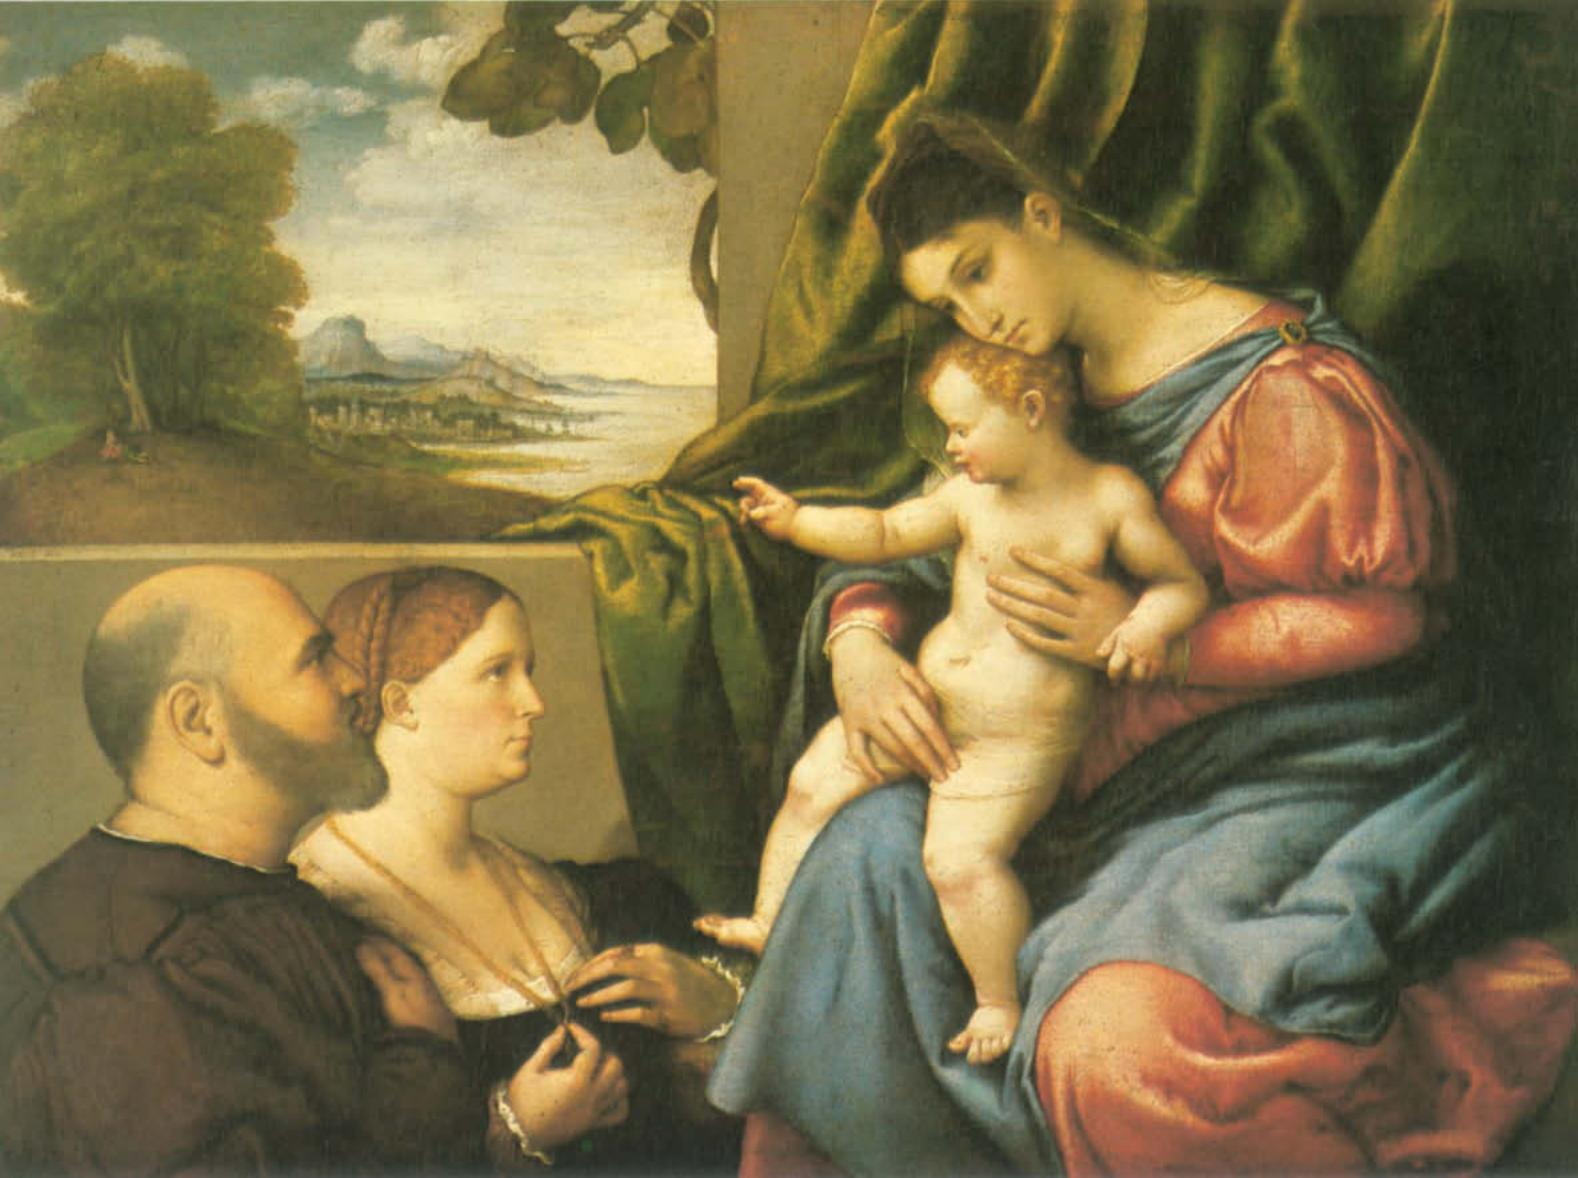


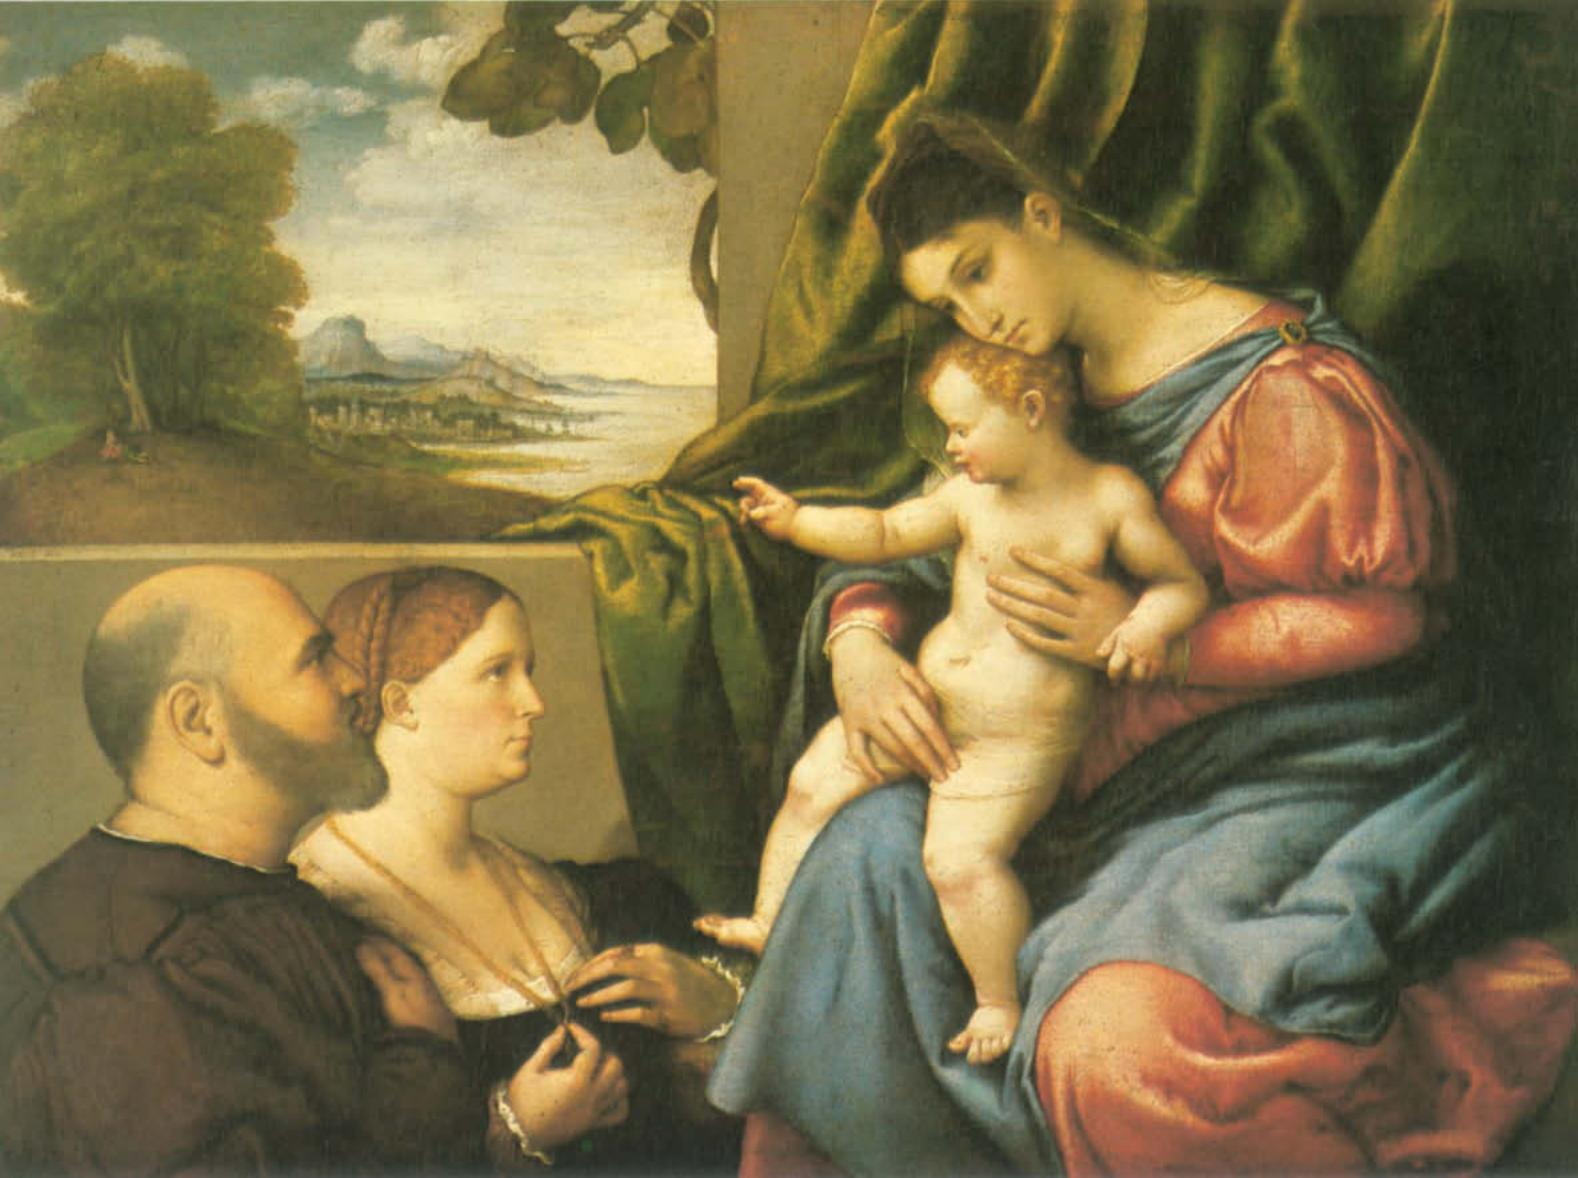


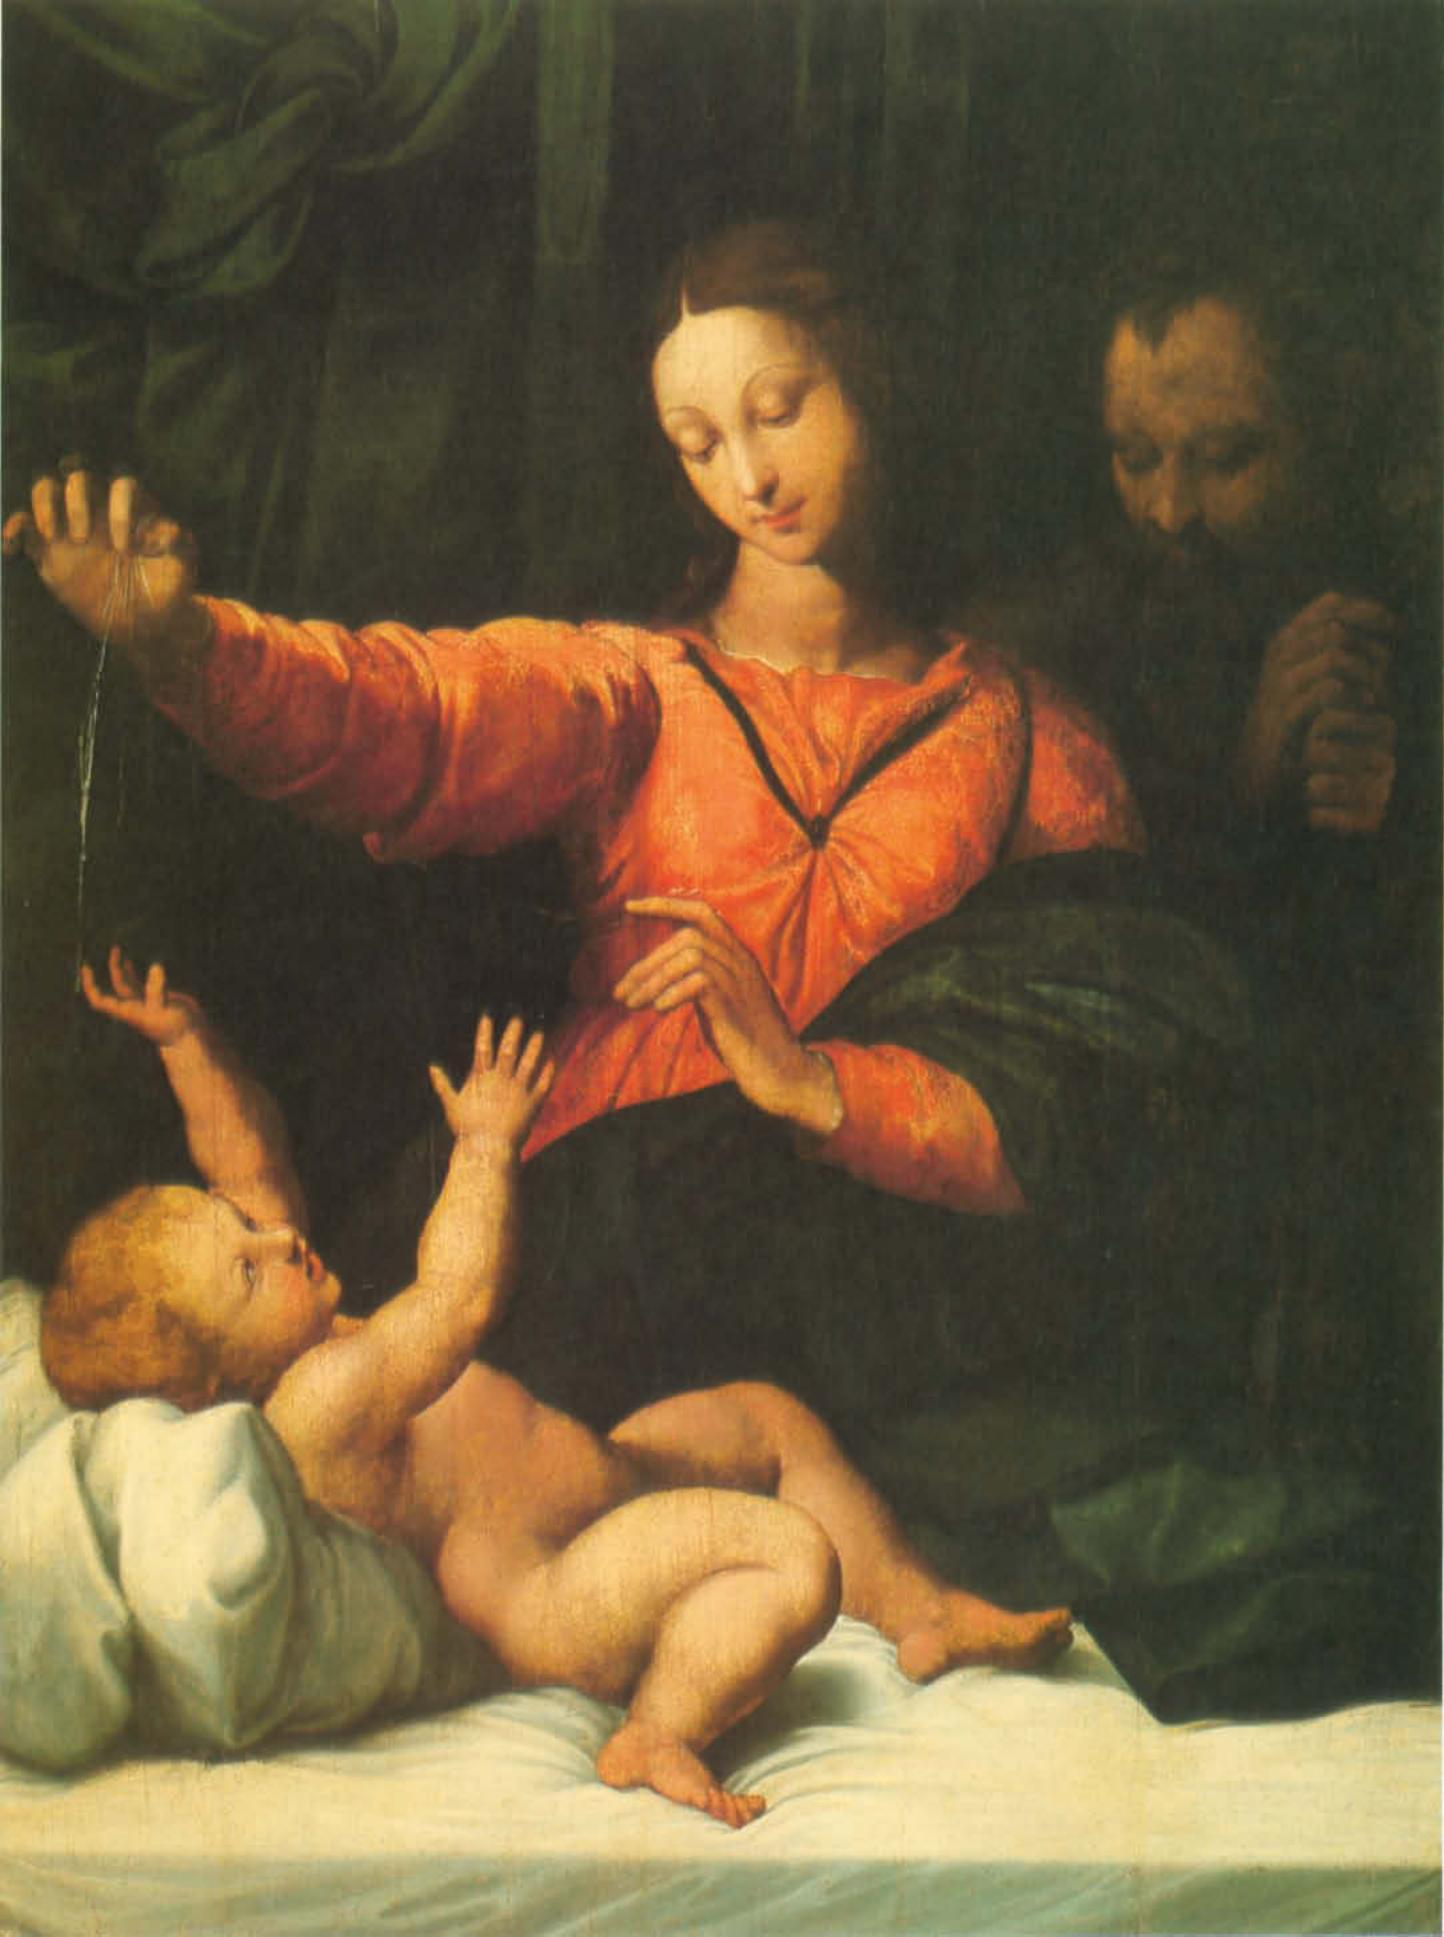


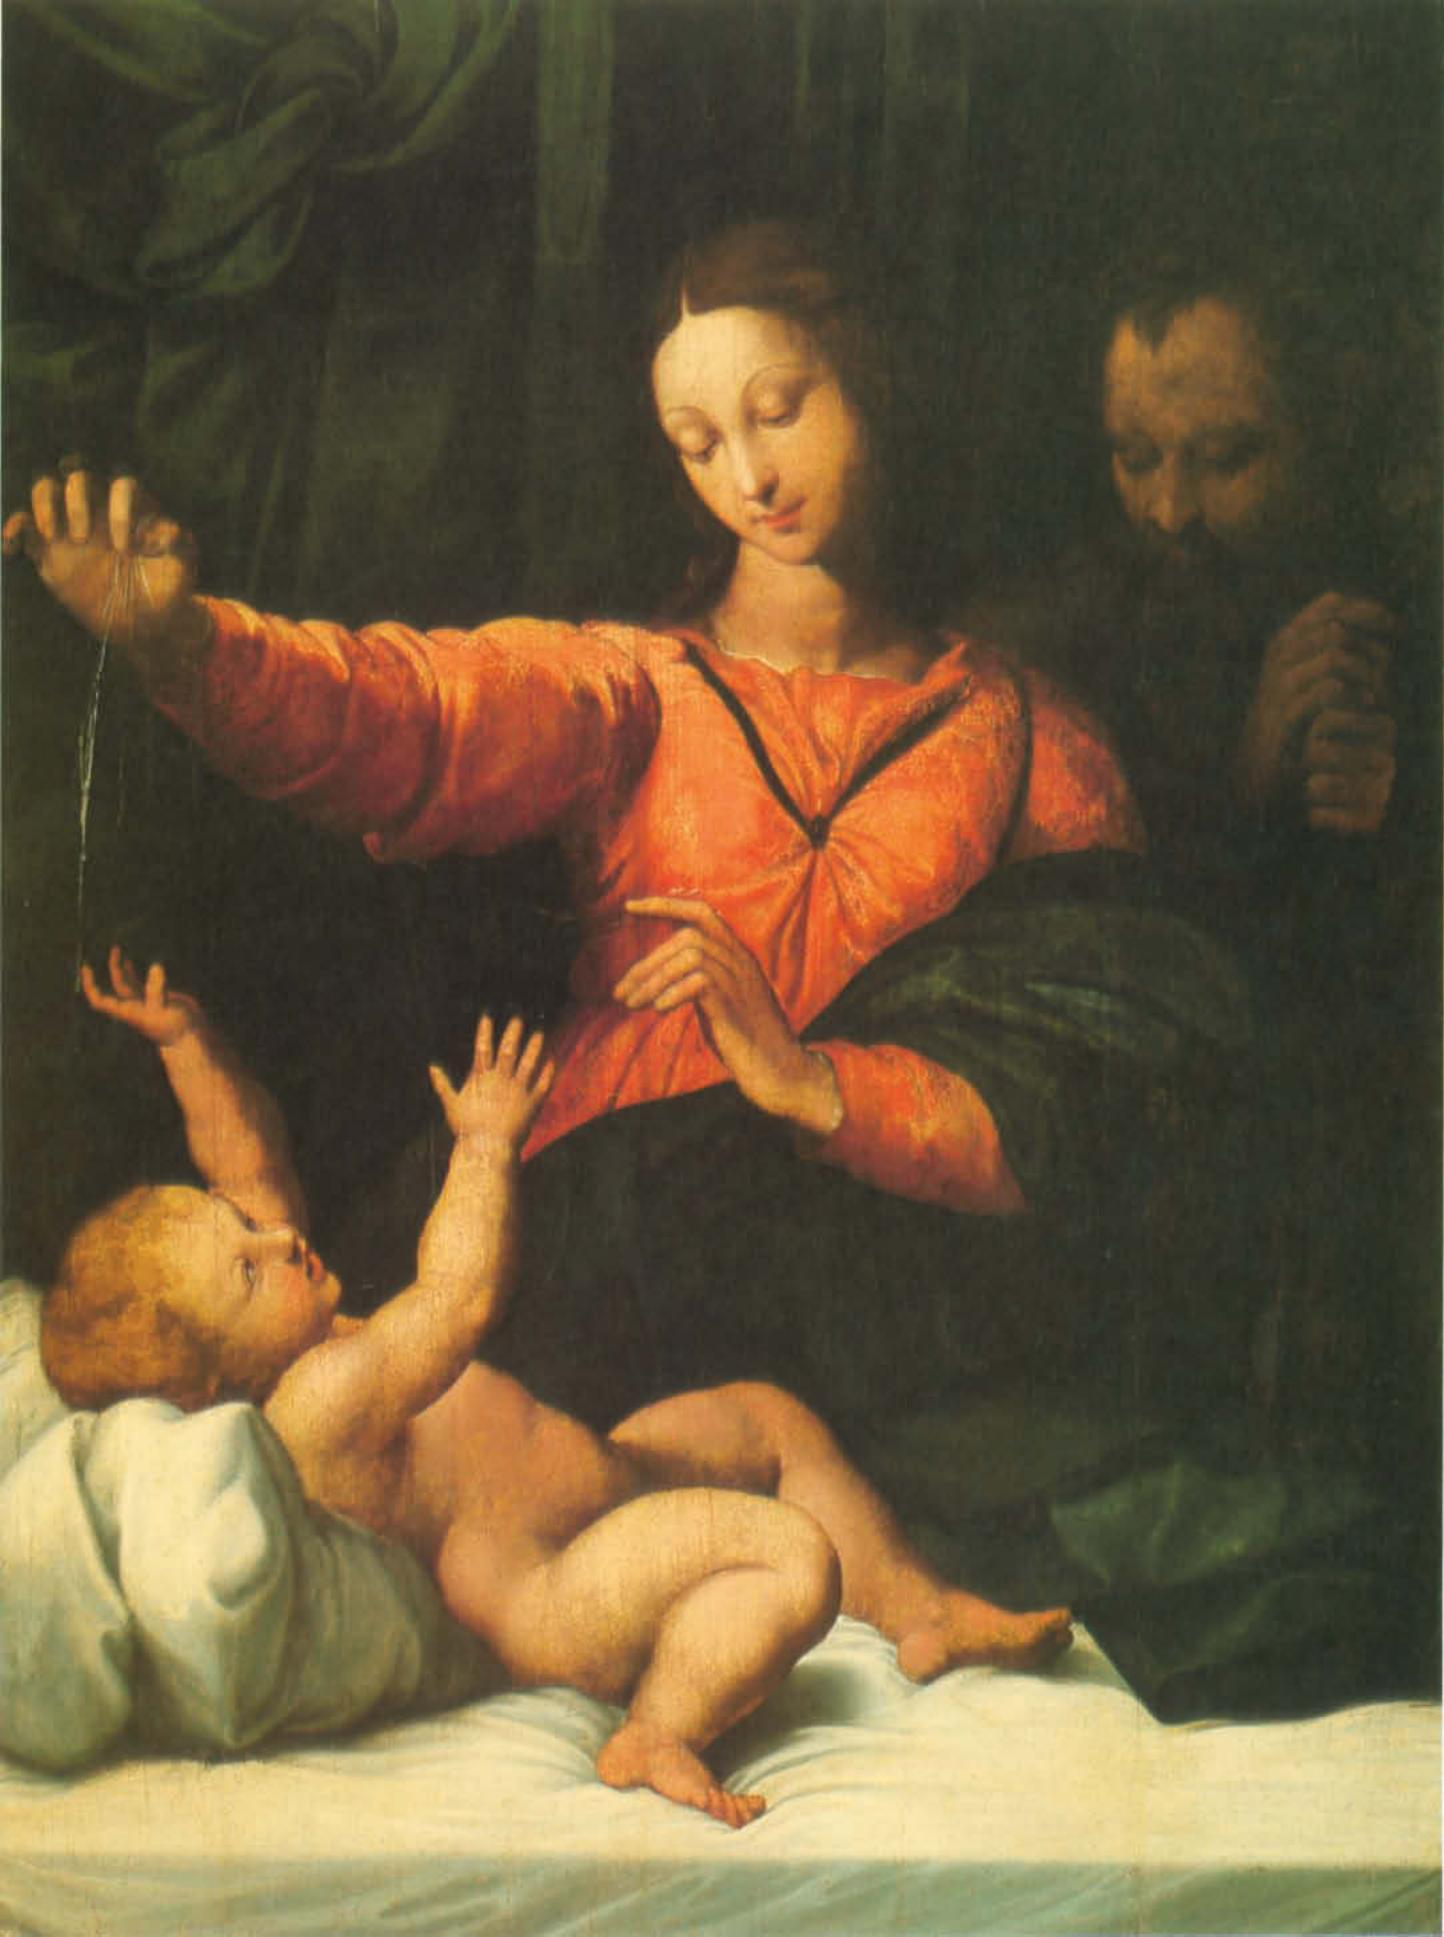

In [13]:
docs = image_retriever.invoke("Women with children", k=5)
for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

In [14]:
chain.invoke("Women with children")

"The image you've provided appears to be a Renaissance painting depicting a religious or allegorical scene. It features four figures: a man and a woman on the left, and a woman holding a child on the right. The man and woman on the left are dressed in clothing that suggests a high social status, possibly indicating they are donors or patrons of the artwork. The woman on the right is seated and wearing a red dress with a blue cloak, colors traditionally associated with the Virgin Mary in Christian art. She is holding a child, likely representing the Christ Child, who is reaching out to the man on the left.\n\nThe background includes a landscape with a clear sky and a hint of architectural structures, which is typical of the period's attempt to incorporate depth and perspective into painting. The figures are arranged in a pyramidal composition, a common technique used during the Renaissance to create a sense of harmony and focus on the central figures.\n\nThe historical and cultural cont

We can see the images retrieved in the LangSmith trace:

LangSmith [trace](https://smith.langchain.com/public/69c558a5-49dc-4c60-a49b-3adbb70f74c5/r/e872c2c8-528c-468f-aefd-8b5cd730a673).